## Import necessary libraries and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import seaborn as sns
import statistics

np.random.seed(27983420)

In [24]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import MaxAbsScaler

I want to have interactive plots and visualizations for my data, so I'm going to use HoloViews.

In [3]:
# put all the HoloViews stuff here
# tbh might not need this? we'll see. 

### Load the cleaned dataset

In [4]:
# load in dataset
mutants = pd.read_csv('../data/interim/k8_clean_data.csv', header=None, low_memory=False)

In [5]:
mutants.head()

,0,1,2,3,4,5,6,7,8,9,...,5400,5401,5402,5403,5404,5405,5406,5407,5408,5409
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,a119e_l125p,inactive
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,a119e_r283k_a353v,inactive
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,c135y,inactive
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,c135y_e285m,inactive
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,c135y_e285v,inactive


In [6]:
# pop out the column of mutants with the nametags, for safekeeping

nametags = mutants.pop(5408).astype(str)
print(nametags)

# since we'll be manipulating the columns of the mutants dataframe, we don't need to keep track of the labels associated with each row

0              a119e_l125p
1        a119e_r283k_a353v
2                    c135y
3              c135y_e285m
4              c135y_e285v
               ...        
16586    y220c_t230c_n239y
16587    y220c_y234f_n239l
16588                y234c
16589          y234c_a119e
16590          y234f_n239l
Name: 5408, Length: 16591, dtype: object


In [26]:
# pop out the target variable column for safekeeping
# change target variable to boolean values

target = mutants.pop(5409).astype(str)
target = target.replace({'inactive': False, 'active': True})
print(target)

0        False
1        False
2        False
3        False
4        False
         ...  
16586     True
16587     True
16588    False
16589    False
16590     True
Name: 5409, Length: 16591, dtype: bool


In [27]:
# new mutants dataframe with only the numerical values
mutants.head()

,0,1,2,3,4,5,6,7,8,9,...,5398,5399,5400,5401,5402,5403,5404,5405,5406,5407
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,-0.015,0.006,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,-0.007,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,-0.016,0.019,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,-0.028,0.051,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,0.027,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013


## Dimensionality Reduction

Due to the highly dimensional nature of this dataset (5408 features!!) and the resulting complexity, knowing where to start is difficult. More common visualization techniques for lower dimensional data are too computationally expensive and time-consuming to be useful at this point. 

Some first steps to reduce dimensionality would be:

1) Search for features with no variance and drop these features, since they do not provide any information for our classification problem.

2) Look for multicollinearity in the features! Identify features that are highly linearly correlated with each other or features that have a high PMI (point-wise mutual information) score. These features are redundant, as having many features with a high PMI score or high linear correlation do not provide additional information. 

Since I am not sure yet whether the features have linear or nonlinear (geometric?) relationships, I will be using both the linear correlation and the PMI scores (mutual information captures non-linear relationships) for the dimensionality reduction and comparing the results of both methods.

### Find Features with No Variance or Low Variance

Using the pandas describe() method, I will be looking for numerical features that have a standard deviation = 0 and min and max values that are equal to each other. These features will be dropped. 

I will also make a note of features that have very low variance, especially compared to the rest of the features, and investigate the relevance of those features further.

In [8]:
desc = mutants.describe()
desc.head()

,0,1,2,3,4,5,6,7,8,9,...,5398,5399,5400,5401,5402,5403,5404,5405,5406,5407
count,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,...,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000,16591.000000
mean,-0.201763,-0.004898,-0.011593,-0.024726,-0.019615,-0.077004,0.222236,0.011294,0.009716,0.009895,...,-0.009736,0.002827,0.004689,0.011400,0.018242,0.001767,-0.011238,0.001415,0.011424,-0.000615
std,0.415089,0.362149,0.244942,0.256497,0.195207,0.539291,1.991421,0.127339,0.210814,0.339393,...,0.011281,0.020840,0.018827,0.024245,0.013061,0.033117,0.009405,0.015348,0.009534,0.022943
min,-6.085000,-7.409000,-4.410000,-3.419000,-3.270000,-2.241000,-0.512000,-0.685000,-0.684000,-0.534000,...,-0.392000,-0.167000,-0.233000,-0.531000,-0.075000,-0.204000,-0.522000,-0.042000,-0.112000,-0.194000
25%,-0.169000,-0.024000,-0.014000,-0.040000,-0.043000,-0.113000,0.006000,0.002000,-0.003000,-0.017000,...,-0.014000,-0.008000,-0.007000,-0.002000,0.011000,-0.019000,-0.012000,-0.006000,0.009000,-0.014000


Before I start removing features, I want to explore the standard deviations of these features. What are the ranges of the standard deviations? What is the smallest standard deviation? What is the largest standard deviation? What is the mean and median standard deviation? Are any of the standard deviations equal to 0? 

Doing this will give me a better idea of which features have relatively low variance and won't be useful.

In [9]:
desc.index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [10]:
descT = desc.T
descT.head()

,count,mean,std,min,25%,50%,75%,max
0,16591.0,-0.201763,0.415089,-6.085,-0.169,-0.162,-0.154,2.323
1,16591.0,-0.004898,0.362149,-7.409,-0.024,-0.010,0.005,4.552
2,16591.0,-0.011593,0.244942,-4.410,-0.014,-0.010,-0.003,2.872
3,16591.0,-0.024726,0.256497,-3.419,-0.040,-0.034,-0.012,17.831
4,16591.0,-0.019615,0.195207,-3.270,-0.043,-0.023,-0.001,4.571


The minimum standard deviation for the original features is 0.006618814893812356
The maximum standard deviation for the original features is 77.3480716547277


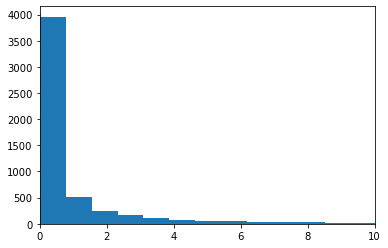

In [11]:
std_min = descT['std'].min()
print("The minimum standard deviation for the original features is {}".format(std_min))

std_max = descT['std'].max()
print("The maximum standard deviation for the original features is {}".format(std_max))

# plot a histogram of the descT['std'] values so that we can see the distribution
#sns.histplot(data=descT, x="std")
_ = plt.hist(x=descT['std'], bins=100)
_ = plt.xlim([0, 10])

The standard deviations have a very large range, and are right skewed. Since the minimum is 0.0066, there aren't any features with a standard deviation of 0, but there are features with standard deviations that are very, very close to 0.

In [12]:
descT.describe() # focus on the 'std' column! 

,count,mean,std,min,25%,50%,75%,max
count,5408.0,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000
mean,16591.0,0.163703,1.188337,-10.564887,-0.275089,0.087606,0.564449,18.131332
std,0.0,3.482811,3.029671,16.820849,3.499720,3.806637,3.824114,31.861964
min,16591.0,-87.251644,0.006619,-255.926167,-91.454000,-86.965000,-82.645000,0.000000
25%,16591.0,-0.030156,0.148570,-11.160500,-0.061000,-0.025000,-0.004000,1.606750
50%,16591.0,0.013918,0.297502,-4.737000,-0.011000,0.011000,0.033000,4.345500
75%,16591.0,0.148052,0.892012,-2.339750,0.023000,0.135000,0.282000,19.545750
max,16591.0,57.955999,77.348072,-0.032000,47.499500,62.450000,71.864000,281.988000


Based on this information about the standard deviations, most of the features have a low variance, or a standard deviation less than 1. Thus, I'll set my cutoff threshold for the "low" standard deviations at 1.0. This should get rid of more than 75% of the features. 

In [13]:
logical = descT['std'] < 1.0
low_var_cols = list(descT.index[logical]) # contains the column numbers of the features with low variances

In [14]:
len(low_var_cols)

4149

In [15]:
mutants.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5409],
           dtype='int64', length=5409)

In [16]:
hv_mutants = mutants.drop(low_var_cols, axis=1)
hv_mutants.head()

,6,10,11,25,106,288,293,294,300,301,...,4813,4814,4815,4816,4817,4820,4821,4822,4825,5409
0,0.025,-0.030,-0.050,-0.031,-0.144053,-4.485,-4.222,-4.109,-0.033,-3.665,...,0.033067,-2.246,-1.037,24.298,48.519,1.971567,0.120300,0.582294,-0.381114,inactive
1,0.013,-0.007,-0.010,-0.019,-0.172632,-4.489,-4.238,-4.111,-0.057,-3.725,...,-1.028600,-1.808,3.705,21.268,62.454,1.771478,-0.112233,0.537647,0.615029,inactive
2,0.038,-0.032,-0.043,-0.036,-0.158158,-4.485,-4.224,-4.107,-0.031,-3.643,...,-0.503633,-2.324,-0.533,24.274,49.118,1.876060,0.648200,0.396000,-0.350229,inactive
3,0.071,-0.044,-0.097,-0.058,-0.038211,-4.484,-4.219,-4.106,-0.145,-3.998,...,0.218600,-2.305,-2.126,16.750,56.411,2.753896,0.537033,0.455118,-3.266400,inactive
4,0.005,0.006,-0.002,-0.011,-0.178263,-4.490,-4.239,-4.110,-0.060,-3.741,...,-1.339100,-2.378,4.155,20.821,61.475,0.856254,-2.289233,0.309824,1.177314,inactive


Using this method, I was able to narrow down my dataset to 1260 features from 5408 features! Now I can filter out even more important features using the following methods.

One important note is that by setting the low variance threshold at 1.0, all of the features above feature 4825 have been dropped - in other words, all of the 3D (distance-based) features had a standard deviation of less than 1.0, and were dropped from the dataframe. Henceforth, all of the further analysis will be done on the remaining 2D features. Investigating *why* the 3D features all had such low variances is important, and requires a sanity check.

### Scale the Numerical Data and Re-Inspect Feature Variances

The scale of the numerical features in this dataset greatly matters when preparing the data for a machine learning model. Since each feature represents a different type of measurement of the p53 proteins, there is a good chance that not all of the features are scaled in the same way. Some of the measurements could have different units or could even have been obtained through different methods! 

One indicator of the uneven scaling of the numerical features is the large right skew that was seen when I visualized the distribution of the unscaled data's standard deviations. Many of the features had very low standard deviations (75% had standard deviations less than 0.89), and a few had much larger standard deviations, with the max standard deviation being 77. 

By scaling the numerical data, I can reduce this skew and more accurately determine which features give little to no information. I will be testing sklearn's MaxAbsScaler and comparing the resulting features list with the unscaled results.

#### Using MaxAbsScaler

In [29]:
# Using MaxAbsScaler
mas = MaxAbsScaler()
mas_mutants = pd.DataFrame(mas.fit_transform(mutants))
mas_mutants.head()

,0,1,2,3,4,5,6,7,8,9,...,5398,5399,5400,5401,5402,5403,5404,5405,5406,5407
0,-0.026459,-0.001890,0.000454,-0.002019,-0.007219,-0.004881,0.001252,0.000791,0.000000,-0.001840,...,-0.038265,0.025641,0.055794,0.039548,0.046189,0.078431,-0.021073,0.005445,0.064516,-0.036082
1,-0.025965,-0.000270,-0.002721,-0.001402,-0.002625,-0.005563,0.000651,0.000791,0.000000,-0.000245,...,-0.017857,0.008547,-0.034335,0.013183,0.034642,-0.039216,-0.021073,-0.007260,0.083871,0.025773
2,-0.027773,-0.003374,-0.002268,-0.002299,-0.009845,-0.003621,0.001903,0.002214,0.001049,-0.001717,...,-0.040816,0.081197,0.042918,0.047081,0.057737,0.102941,-0.022989,0.010889,0.103226,-0.092784
3,-0.030074,-0.006884,-0.005215,-0.004318,-0.020127,-0.000787,0.003556,0.004271,0.002623,-0.002330,...,-0.071429,0.217949,0.051502,0.094162,0.087760,0.250000,-0.028736,0.030853,0.174194,-0.252577
4,-0.025308,0.000675,-0.002494,-0.000729,-0.000438,-0.006036,0.000250,0.000316,-0.000393,0.000245,...,0.068878,-0.047009,0.051502,0.016949,0.006928,-0.004902,0.003831,-0.010889,0.058065,0.067010


The minimum standard deviation for the Max Abs Scaled features is 0.007958482344045307
The maximum standard deviation for the Max Abs Scaled features is 0.502363693709944


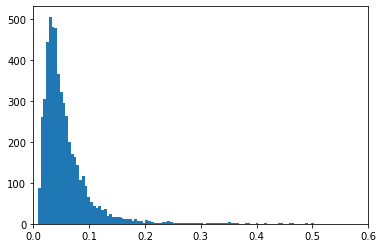

In [39]:
mas_desc = mas_mutants.describe()
mas_descT = mas_desc.T

std_min = mas_descT['std'].min()
print("The minimum standard deviation for the Max Abs Scaled features is {}".format(std_min))

std_max = mas_descT['std'].max()
print("The maximum standard deviation for the Max Abs Scaled features is {}".format(std_max))

# plot a histogram of the mas_descT['std'] values so that we can see the distribution
_ = plt.hist(x=mas_descT['std'], bins=100)
_ = plt.xlim([0, 0.6])

In [33]:
mas_descT.describe()

,count,mean,std,min,25%,50%,75%,max
count,5408.0,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000
mean,16591.0,0.003436,0.057177,-0.720603,-0.014358,0.001879,0.022439,0.763602
std,0.0,0.072722,0.046824,0.324982,0.087797,0.086291,0.071768,0.316891
min,16591.0,-0.626085,0.007958,-1.000000,-0.901205,-0.900000,-0.623126,0.000000
25%,16591.0,-0.007855,0.030296,-1.000000,-0.014298,-0.006195,-0.000910,0.522188
50%,16591.0,0.002711,0.044439,-0.906027,-0.002026,0.002046,0.006816,1.000000
75%,16591.0,0.017042,0.068514,-0.431275,0.003488,0.014670,0.031127,1.000000
max,16591.0,0.612498,0.502364,-0.008848,0.612200,0.718772,0.726974,1.000000


In [36]:
logical = mas_descT['std'] < 0.1
mas_low_var_cols = list(mas_descT.index[logical])
len(mas_low_var_cols)

4853

In [37]:
# drop the features
MAS_mutants = mutants.drop(mas_low_var_cols, axis=1)
MAS_mutants.head()

,25,86,106,131,288,292,293,294,297,298,...,5278,5282,5283,5330,5331,5369,5377,5387,5403,5407
0,-0.031,-0.024,-0.144053,-0.021,-4.485,-0.694,-4.222,-4.109,0.003,-0.004,...,0.041,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,0.016,-0.007
1,-0.019,0.006,-0.172632,-0.038,-4.489,-0.689,-4.238,-4.111,0.006,-0.002,...,0.022,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,-0.008,0.005
2,-0.036,-0.056,-0.158158,-0.033,-4.485,-0.696,-4.224,-4.107,-0.012,-0.017,...,0.047,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,0.021,-0.018
3,-0.058,-0.116,-0.038211,-0.039,-4.484,-0.701,-4.219,-4.106,-0.038,-0.043,...,0.073,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,0.051,-0.049
4,-0.011,0.012,-0.178263,-0.037,-4.490,-0.688,-4.239,-4.110,0.011,0.004,...,0.015,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,-0.001,0.013


By using MaxAbsScaler before looking at the feature variances, I was able to reduce the dimensionality of my data from 5408 features to 555 features. Additionally, this new dataset preserves some of both the 2D and 3D features, whereas the previous method (without scaling data) got rid of all of the 3D features. This tells me that the 2D features and 3D features are scaled different from each other, so using MaxAbsScaler beforehand was a good choice here.

Continuing on, I will be using the feature set from MAS_mutants for my analysis.

### Using Linear Correlation to Reduce Dimensionality

My strategy for dimensionality reduction using linear correlation, excluding non-numerical features, is as follows:

1) Start by looking at only the 2D, or electrostatic and surface-based features. This will be all features (or columns) up to feature 4826, in the dataset.

2) Calculate the linear correlation of the first two features with each other. This is a measure of the **redundancy** of the two features.
    
    (a) If this value is higher than the chosen threshold value, then that tells me that the two features are collinear and are redundant. Now, decide which of the two features to drop by proceeding to step #3.
    
    (b) If this value is lower than the chosen threshold value, then that tells me that the two features are not collinear and both features will be retained in the dataset. Proceed to step #4.

3) Take the two features from step #2 and calculate their correlation with the rest of the features. This will give a [2 x 555] correlation matrix. Calculate the median of the values of each row, giving two numbers which summarize how highly correlated the two features are with the rest of the 2D features, aka **the relevancy of that feature to the rest of the dataset**. *The average is susceptible to bias from outliers, so the median is a better summary statistic* 
    
    (a) If one of the two values is much larger than the other, then drop the feature with the larger value since that feature has more repeated information over the whole dataset than the other feature. If the two values are the same, then drop the first feature.

4) Move on to the next two features and repeat the process for all of the 2D features. 

5) After subsetting the 2D features in this way, repeat the process with the 3D (distance-based) features and combine the data. 

6) Investigate the relationships of the selected features with the target variable (inactive or active). 

In [44]:
MAS_list = list(MAS_mutants.columns) # check the remaining column names
MAS_len = len(MAS_list)
#MAS_corr = MAS_mutants.corr()

In [51]:
MAS_mutants.head()

,25,86,106,131,288,292,293,294,297,298,...,5278,5282,5283,5330,5331,5369,5377,5387,5403,5407
0,-0.031,-0.024,-0.144053,-0.021,-4.485,-0.694,-4.222,-4.109,0.003,-0.004,...,0.041,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,0.016,-0.007
1,-0.019,0.006,-0.172632,-0.038,-4.489,-0.689,-4.238,-4.111,0.006,-0.002,...,0.022,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,-0.008,0.005
2,-0.036,-0.056,-0.158158,-0.033,-4.485,-0.696,-4.224,-4.107,-0.012,-0.017,...,0.047,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,0.021,-0.018
3,-0.058,-0.116,-0.038211,-0.039,-4.484,-0.701,-4.219,-4.106,-0.038,-0.043,...,0.073,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,0.051,-0.049
4,-0.011,0.012,-0.178263,-0.037,-4.490,-0.688,-4.239,-4.110,0.011,0.004,...,0.015,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,-0.001,0.013


In [84]:
print(sum(MAS_mutants.columns <= 4826)) # number of remaining 2D features
print(sum(MAS_mutants.columns > 4826)) # number of remaining 3D features

513
42


In [85]:
# separate MAS_mutants into 2D and 3D feature sets so the analysis can be done separately
MAS_mutants_2D = MAS_mutants[MAS_mutants.columns[0:513]]

MAS_mutants_3D = MAS_mutants[MAS_mutants.columns[513:]]

In [87]:
MAS_mutants_2D.head()

,25,86,106,131,288,292,293,294,297,298,...,4802,4804,4809,4813,4814,4816,4817,4821,4822,4824
0,-0.031,-0.024,-0.144053,-0.021,-4.485,-0.694,-4.222,-4.109,0.003,-0.004,...,-18.015,-14.342,-1.213727,0.033067,-2.246,24.298,48.519,0.120300,0.582294,0.227375
1,-0.019,0.006,-0.172632,-0.038,-4.489,-0.689,-4.238,-4.111,0.006,-0.002,...,-9.978,4.115,-0.619045,-1.028600,-1.808,21.268,62.454,-0.112233,0.537647,0.278125
2,-0.036,-0.056,-0.158158,-0.033,-4.485,-0.696,-4.224,-4.107,-0.012,-0.017,...,-17.386,-11.706,0.489000,-0.503633,-2.324,24.274,49.118,0.648200,0.396000,0.027750
3,-0.058,-0.116,-0.038211,-0.039,-4.484,-0.701,-4.219,-4.106,-0.038,-0.043,...,-23.006,-23.103,-1.607500,0.218600,-2.305,16.750,56.411,0.537033,0.455118,0.050625
4,-0.011,0.012,-0.178263,-0.037,-4.490,-0.688,-4.239,-4.110,0.011,0.004,...,-9.191,2.702,-1.240091,-1.339100,-2.378,20.821,61.475,-2.289233,0.309824,-0.122750


In [88]:
MAS_mutants_3D.head()

,4841,4844,4845,4881,4886,4901,4933,4941,4944,4948,...,5278,5282,5283,5330,5331,5369,5377,5387,5403,5407
0,0.055,0.005,0.020,-0.005,-0.060,-0.049,-0.034,-0.029,-0.004000,-0.003,...,0.041,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,0.016,-0.007
1,0.011,-0.012,0.007,-0.003,-0.082,-0.029,-0.017,0.143,0.010000,0.002,...,0.022,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,-0.008,0.005
2,0.054,0.012,0.010,-0.009,-0.070,-0.055,-0.027,-0.019,-0.002000,-0.006,...,0.047,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,0.021,-0.018
3,0.090,0.028,-0.003,-0.021,-0.103,-0.082,-0.065,0.002,-0.492000,0.144,...,0.073,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,0.051,-0.049
4,0.001,-0.014,0.012,0.007,-0.030,-0.027,-0.011,-0.008,-0.371001,0.106,...,0.015,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,-0.001,0.013


#### Filtering Collinear 2D Features

In [89]:
# start by calulating the corr matrix of the 2D features first
MAS_2D_corr = MAS_mutants_2D.corr().abs() # make all the elements positive

In [90]:
MAS_2D_corr.head()

,25,86,106,131,288,292,293,294,297,298,...,4802,4804,4809,4813,4814,4816,4817,4821,4822,4824
25,1.000000,0.010741,0.013168,0.028168,0.024823,0.016069,0.024333,0.024354,0.009462,0.010356,...,0.001487,0.007152,0.014403,0.012680,0.004763,0.030066,0.026135,0.007501,0.014239,0.023754
86,0.010741,1.000000,0.054569,0.045302,0.067544,0.009928,0.060062,0.056202,0.024092,0.020681,...,0.078875,0.114014,0.064595,0.032429,0.013633,0.096374,0.095062,0.066786,0.005137,0.026684
106,0.013168,0.054569,1.000000,0.020465,0.321220,0.194469,0.311122,0.307030,0.087466,0.089971,...,0.093871,0.085181,0.008371,0.040578,0.040519,0.240945,0.343914,0.005108,0.067246,0.135342
131,0.028168,0.045302,0.020465,1.000000,0.057601,0.043589,0.059245,0.057614,0.021267,0.026795,...,0.161149,0.213068,0.122095,0.032176,0.082033,0.093976,0.050512,0.132942,0.049815,0.024093
288,0.024823,0.067544,0.321220,0.057601,1.000000,0.743613,0.991983,0.986423,0.464675,0.479323,...,0.102764,0.041005,0.047026,0.054588,0.100053,0.711181,0.729181,0.005661,0.030826,0.105050


I made all the elements in the correlation matrix positive, because I only want to see if features are highly correlated at this point, not whether the features are positively correlated or negatively correlated.

In [91]:
upper_2D = MAS_2D_corr.where(np.triu(np.ones(MAS_2D_corr.shape), k=1).astype(np.bool)) # make upper triangular matrix
upper_2D.head()
# ref: Chris Albon

,25,86,106,131,288,292,293,294,297,298,...,4802,4804,4809,4813,4814,4816,4817,4821,4822,4824
25,NaN,0.010741,0.013168,0.028168,0.024823,0.016069,0.024333,0.024354,0.009462,0.010356,...,0.001487,0.007152,0.014403,0.012680,0.004763,0.030066,0.026135,0.007501,0.014239,0.023754
86,NaN,NaN,0.054569,0.045302,0.067544,0.009928,0.060062,0.056202,0.024092,0.020681,...,0.078875,0.114014,0.064595,0.032429,0.013633,0.096374,0.095062,0.066786,0.005137,0.026684
106,NaN,NaN,NaN,0.020465,0.321220,0.194469,0.311122,0.307030,0.087466,0.089971,...,0.093871,0.085181,0.008371,0.040578,0.040519,0.240945,0.343914,0.005108,0.067246,0.135342
131,NaN,NaN,NaN,NaN,0.057601,0.043589,0.059245,0.057614,0.021267,0.026795,...,0.161149,0.213068,0.122095,0.032176,0.082033,0.093976,0.050512,0.132942,0.049815,0.024093
288,NaN,NaN,NaN,NaN,NaN,0.743613,0.991983,0.986423,0.464675,0.479323,...,0.102764,0.041005,0.047026,0.054588,0.100053,0.711181,0.729181,0.005661,0.030826,0.105050


In [92]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

# ref: https://thispointer.com/python-find-indexes-of-an-element-in-pandas-dataframe/

In [98]:
# find which 2D features to drop from MAS_mutants_2D
to_drop = []

for _,x in upper_2D.iterrows():
    for y in x:
        if y >= 0.90:
            tup = getIndexes(upper_2D, y)[0]
            if (tup[0] in to_drop) or (tup[1] in to_drop):
                continue
            
            avg1 = MAS_2D_corr[tup[0]].mean()
            avg2 = MAS_2D_corr[tup[1]].mean()
            if avg1 >= avg2:
                to_drop.append(tup[0])
            else:
                to_drop.append(tup[1])
        else:
            continue

In [100]:
len(to_drop)

200

This method returns 200 of the 2D features that are highly correlated. 

In [102]:
MAS_2D = MAS_mutants_2D.drop(to_drop, axis=1)
MAS_2D.head()

,25,86,131,294,297,307,321,340,345,346,...,4802,4804,4809,4813,4814,4816,4817,4821,4822,4824
0,-0.031,-0.024,-0.021,-4.109,0.003,-0.103000,2.551,3.024,-0.442,-0.001,...,-18.015,-14.342,-1.213727,0.033067,-2.246,24.298,48.519,0.120300,0.582294,0.227375
1,-0.019,0.006,-0.038,-4.111,0.006,-0.054667,-0.002,2.952,-0.366,0.009,...,-9.978,4.115,-0.619045,-1.028600,-1.808,21.268,62.454,-0.112233,0.537647,0.278125
2,-0.036,-0.056,-0.033,-4.107,-0.012,-0.099333,-0.002,3.031,-0.089,-0.019,...,-17.386,-11.706,0.489000,-0.503633,-2.324,24.274,49.118,0.648200,0.396000,0.027750
3,-0.058,-0.116,-0.039,-4.106,-0.038,-0.134333,-0.017,-0.033,-0.056,-0.046,...,-23.006,-23.103,-1.607500,0.218600,-2.305,16.750,56.411,0.537033,0.455118,0.050625
4,-0.011,0.012,-0.037,-4.110,0.011,-0.057333,0.000,2.974,-0.362,0.017,...,-9.191,2.702,-1.240091,-1.339100,-2.378,20.821,61.475,-2.289233,0.309824,-0.122750


#### Filtering Collinear 3D Features

I will now apply the same strategy to the 3D features! 

In [103]:
MAS_3D_corr = MAS_mutants_3D.corr().abs()

In [104]:
upper_3D = MAS_3D_corr.where(np.triu(np.ones(MAS_3D_corr.shape), k=1).astype(np.bool)) # make upper triangular matrix
upper_3D.head()

,4841,4844,4845,4881,4886,4901,4933,4941,4944,4948,...,5278,5282,5283,5330,5331,5369,5377,5387,5403,5407
4841,NaN,0.904157,0.310333,0.770910,0.829129,0.808120,0.898894,0.196376,0.114561,0.161840,...,0.062539,0.700426,0.571774,0.767891,0.871860,0.704920,0.654153,0.833359,0.896254,0.881774
4844,NaN,NaN,0.408085,0.697986,0.756815,0.727491,0.844102,0.186730,0.096044,0.145786,...,0.079157,0.646688,0.496119,0.722079,0.770150,0.625637,0.589960,0.762503,0.816360,0.782036
4845,NaN,NaN,NaN,0.230518,0.247912,0.217177,0.378342,0.177637,0.077229,0.122669,...,0.038879,0.272281,0.134763,0.103923,0.336501,0.086260,0.142321,0.255248,0.268374,0.158142
4881,NaN,NaN,NaN,NaN,0.721688,0.682630,0.730488,0.173161,0.100830,0.127764,...,0.041767,0.578502,0.487974,0.616440,0.699432,0.592666,0.541698,0.675994,0.744315,0.741920
4886,NaN,NaN,NaN,NaN,NaN,0.738641,0.785261,0.201404,0.125795,0.160995,...,0.033617,0.625263,0.534592,0.663907,0.751926,0.627448,0.562394,0.811855,0.807225,0.803835


In [105]:
# find which 3D features to drop from MAS_mutants_3D
to_drop = []

for _,x in upper_3D.iterrows():
    for y in x:
        if y >= 0.90:
            tup = getIndexes(upper_3D, y)[0]
            if (tup[0] in to_drop) or (tup[1] in to_drop):
                continue
            
            avg1 = MAS_3D_corr[tup[0]].mean()
            avg2 = MAS_3D_corr[tup[1]].mean()
            if avg1 >= avg2:
                to_drop.append(tup[0])
            else:
                to_drop.append(tup[1])
        else:
            continue

In [106]:
len(to_drop) # number of 3D features to drop

13

In [107]:
MAS_3D = MAS_mutants_3D.drop(to_drop, axis=1)
MAS_3D.head()

,4844,4845,4881,4886,4901,4933,4944,5052,5065,5066,...,5262,5275,5282,5283,5330,5331,5369,5377,5387,5407
0,0.005,0.020,-0.005,-0.060,-0.049,-0.034,-0.004000,0.025,-0.034,-0.014,...,-0.029,0.050,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,-0.007
1,-0.012,0.007,-0.003,-0.082,-0.029,-0.017,0.010000,0.005,-0.021,-0.021,...,-0.012,0.034,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,0.005
2,0.012,0.010,-0.009,-0.070,-0.055,-0.027,-0.002000,0.042,-0.029,-0.015,...,-0.032,0.053,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,-0.018
3,0.028,-0.003,-0.021,-0.103,-0.082,-0.065,-0.492000,0.038,-0.042,0.003,...,-0.069,0.076,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,-0.049
4,-0.014,0.012,0.007,-0.030,-0.027,-0.011,-0.371001,0.004,-0.017,-0.019,...,-0.012,0.024,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,0.013


#### Combine 2D and 3D Feature Sets

In [109]:
MAS_lin_comb = pd.concat([MAS_2D, MAS_3D], axis=1)
MAS_lin_comb.shape

(16591, 342)

In [110]:
MAS_lin_comb = pd.concat([MAS_lin_comb, target, nametags], axis=1)
MAS_lin_comb.head()

,25,86,131,294,297,307,321,340,345,346,...,5282,5283,5330,5331,5369,5377,5387,5407,5409,5408
0,-0.031,-0.024,-0.021,-4.109,0.003,-0.103000,2.551,3.024,-0.442,-0.001,...,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,-0.007,False,a119e_l125p
1,-0.019,0.006,-0.038,-4.111,0.006,-0.054667,-0.002,2.952,-0.366,0.009,...,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,0.005,False,a119e_r283k_a353v
2,-0.036,-0.056,-0.033,-4.107,-0.012,-0.099333,-0.002,3.031,-0.089,-0.019,...,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,-0.018,False,c135y
3,-0.058,-0.116,-0.039,-4.106,-0.038,-0.134333,-0.017,-0.033,-0.056,-0.046,...,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,-0.049,False,c135y_e285m
4,-0.011,0.012,-0.037,-4.110,0.011,-0.057333,0.000,2.974,-0.362,0.017,...,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,0.013,False,c135y_e285v


In [111]:
lin_df = MAS_lin_comb.rename({5409: 'activity', 5408: 'nametags'}, axis='columns')
lin_df.head()

,25,86,131,294,297,307,321,340,345,346,...,5282,5283,5330,5331,5369,5377,5387,5407,activity,nametags
0,-0.031,-0.024,-0.021,-4.109,0.003,-0.103000,2.551,3.024,-0.442,-0.001,...,0.030,-0.028,-0.033,0.046,0.058,-0.087,0.035,-0.007,False,a119e_l125p
1,-0.019,0.006,-0.038,-4.111,0.006,-0.054667,-0.002,2.952,-0.366,0.009,...,0.005,-0.018,-0.016,0.021,0.047,-0.035,0.011,0.005,False,a119e_r283k_a353v
2,-0.036,-0.056,-0.033,-4.107,-0.012,-0.099333,-0.002,3.031,-0.089,-0.019,...,0.028,-0.033,-0.038,0.044,0.074,-0.076,0.036,-0.018,False,c135y
3,-0.058,-0.116,-0.039,-4.106,-0.038,-0.134333,-0.017,-0.033,-0.056,-0.046,...,0.053,-0.050,-0.061,0.061,0.126,-0.124,0.059,-0.049,False,c135y_e285m
4,-0.011,0.012,-0.037,-4.110,0.011,-0.057333,0.000,2.974,-0.362,0.017,...,0.005,-0.013,-0.008,0.016,0.024,-0.035,0.009,0.013,False,c135y_e285v


In [112]:
# save lin_df as a file for later in the processed data folder

#lin_filtered_file = lin_df.to_csv(r'C:\Users\Shakuntala Mitra\p53_Rescue_Mutants\data\processed\lin_filtered_data.csv', index=False, header=False)


### Using Mutual Information to Reduce Dimensionality

My strategy for dimensionality reduction using mutual information is as follows:

1) Determine a threshold value for the PMI score. 

2) Take the first two features (columns) and calculate the PMI score between them. 

    (a) If the PMI score is large (above threshold value), then that means that those two features are highly dependent. In this case, keep the feature with the largest information gain and store in a dataframe. The other feature will be removed and stored in a separate dataframe. 
    
    (b) If the PMI score is low (below threshold value), then those two features are weakly correlated and both features may be retained. 
    
    (c) If the PMI score is 0, then the two features are statistically independent and both features may be retained.


3) Repeat the process with the next set of two features until all the 2D features have been tested. 

4) Continue the process with the 3D features.

Afterwards, I will investigate the relationships of the remaining features with the target variable.

In [ ]:
def mutual_information(self, x_index, y_index, log_base, debug = False):
        """
        Calculate and return Mutual information between two random variables
        """
        # Check if index are into the bounds
        assert (x_index >= 0 and x_index <= self.n_rows)
        assert (y_index >= 0 and y_index <= self.n_rows)
        # Variable to return MI
        summation = 0.0
        # Get uniques values of random variables
        values_x = set(data[x_index])
        values_y = set(data[y_index])
        # Print debug info
        if debug:
            print 'MI between'
            print data[x_index]
            print data[y_index]
        # For each random
        for value_x in values_x:
            for value_y in values_y:
                px = shape(where(data[x_index]==value_x))[1] / self.n_cols
                py = shape(where(data[y_index]==value_y))[1] / self.n_cols
                pxy = len(where(in1d(where(data[x_index]==value_x)[0], 
                                where(data[y_index]==value_y)[0])==True)[0]) / self.n_cols
                if pxy > 0.0:
                    summation += pxy * math.log((pxy / (px*py)), log_base)
                if debug:
                    print '(%d,%d) px:%f py:%f pxy:%f' % (value_x, value_y, px, py, pxy)
        return summation
    

# source: https://github.com/rmaestre/Mutual-Information/blob/master/it_tool.py